In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
C:\Users\chimd\Anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* CAD/JPY exchange rate returns. 

In [2]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [3]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Data Preparation

### Returns

In [4]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
cad_jpy_df['Return'] = cad_jpy_df.Price.pct_change()*100
cad_jpy_df.replace(-np.inf, np.nan)
cad_jpy_df=cad_jpy_df.dropna()
cad_jpy_df.head()

,Price,Open,High,Low,Return
Date,,,,,
1990-01-03,125.30,125.24,125.30,125.24,-0.846720
1990-01-04,123.46,123.41,123.46,123.41,-1.468476
1990-01-05,124.54,124.48,124.54,124.48,0.874777
1990-01-08,124.27,124.21,124.27,124.21,-0.216798
1990-01-09,125.10,125.04,125.10,125.04,0.667901


### Lagged Returns 

In [5]:
# Create a lagged return using the shift function
cad_jpy_df['Return_Lagged']=cad_jpy_df.Return.shift()
cad_jpy_df=cad_jpy_df.dropna()
cad_jpy_df.head()

,Price,Open,High,Low,Return,Return_Lagged
Date,,,,,,
1990-01-04,123.46,123.41,123.46,123.41,-1.468476,-0.846720
1990-01-05,124.54,124.48,124.54,124.48,0.874777,-1.468476
1990-01-08,124.27,124.21,124.27,124.21,-0.216798,0.874777
1990-01-09,125.10,125.04,125.10,125.04,0.667901,-0.216798
1990-01-10,125.81,125.75,125.81,125.75,0.567546,0.667901


### Train Test Split

In [6]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = cad_jpy_df[:'2017']
test = cad_jpy_df['2018':'2019']

In [7]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = train.Return_Lagged
X_test = test.Return_Lagged
y_train = train.Return.tolist()
y_test = test.Return.tolist()

In [8]:
# Preview the X_train data
X_train.head()

Date
1990-01-04   -0.846720
1990-01-05   -1.468476
1990-01-08    0.874777
1990-01-09   -0.216798
1990-01-10    0.667901
Name: Return_Lagged, dtype: float64

In [9]:
X_train1 = X_train.values.reshape(-1,1)
X_test1 = X_test.values.reshape(-1,1)

# Linear Regression Model

In [10]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using  just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train1, y_train)

LinearRegression()

# Make predictions using the Testing Data

**Note:** We want to evaluate the model using data that it has never seen before, in this case: `X_test`.

In [11]:
# Make a prediction of "y" values using just the test dataset
y_predict=model.predict(X_test1)

In [12]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
comparison = pd.DataFrame();
comparison['True_value'] = y_test
comparison['Prediction'] = y_predict

comparison.head()

,True_value,Prediction
0,0.245591,0.005434
1,-0.055679,-0.007317
2,0.011142,0.000340
3,0.601604,-0.001358
4,0.919158,-0.016366


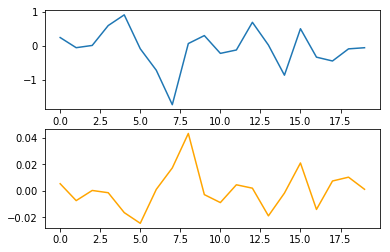

In [13]:
# Plot the first 20 predictions vs the true values
fig, axs = plt.subplots(2)
axs[0].plot(comparison.index[:20],comparison.True_value[:20])
axs[1].plot(comparison.index[:20],comparison.Prediction[:20], color = 'Orange')

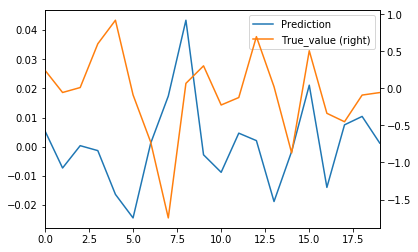

In [14]:
# Plot the first 20 predictions vs the true values
comparison.Prediction[:20].plot(legend=True);
comparison.True_value[:20].plot(secondary_y=True, legend=True)

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (`X_test` and `y_test`)

In [15]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
# (Hint: use the dataframe from above)
mse = mean_squared_error(comparison.True_value, comparison.Prediction)

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse=np.sqrt(mse)

# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [188]:
# Construct a dataframe using just the "y" training data:
y_train_df = pd.DataFrame(y_train)

# Add a column of "in-sample" predictions to that dataframe:  
y_train_df['In_Sample'] = model.predict(X_train1)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
mse1 = mean_squared_error(y_train, y_train_df.In_Sample)

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
rmse1=np.sqrt(mse1)

#print(mse)
print(rmse)
#print(mse1)
print(rmse1)

0.5228175752219729
0.841994632894117


# Conclusions

**Question:** Does this model perform better or worse on out-of-sample data as compared to in-sample data?

**Answer:** Model performs better for out-of-sample data compared to in-sample data.